# Metalens Optimization for the Far Field Design Case, using PyTorch

This notebook demonstrates the use of the metalens optmization library for the COPILOT far field design case.
PyTorch is used as the backend framework for automatic differentiation.

## Configure Compute Devices

In [1]:
# Choose which device to use.
use_GPU = False
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_GPU else '/CPU:0'

# Import device utils.
import sys
import os
sys.path.append('./src/')
sys.path.append('./rcwa_pt/src/')
import utils

if use_GPU: 
    # Configure GPUs.
    utils.config_gpu_memory_usage()

2023-03-20 16:57:53.876607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 16:57:54.009593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 16:57:54.009610: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 16:57:54.637512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dependencies

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import solver_pt
import solver_metasurface_pt

## Configure Optimization Parameters

Change the parameters here in order to configure the design case being optimized for, choose algorithm hyperparameters, or set logging behavior.

In [3]:
# Initialize parameters dictionary.
user_params = {}

##########
# Algorithm hyperparameters.
# These values subject to a hyperparameter grid search. These default values are used if the grid search is disabled.
##########

# Maximum number of optimization iterations.
user_params['N'] = 10

# Coefficient used for differentiable thresholding annealing.
# At each optimization step, the coefficient of the sigmoid function used to force admissable solutions
# is increased by the increment N / sigmoid_update.
user_params['sigmoid_update'] = 10.0

# Learning rate provided to Keras optimizer.
user_params['learning_rate'] = 8E-1

# Initial height of each of the device pixels.
# Should be in the range [0, Nlay-1], where Nlay is the number of device layers
# (specified as the length of the parameter L below).
user_params['initial_height'] = 0

# Flag to enable hyperparameter grid search.
user_params['enable_hyperparameter_gridsearch'] = False

# Values to use in hyperparameter grid search.
# Stored as a dict. Each dict key is the key in user_params corresponding to a tunable hyperparameter, i.e. 'N',
# and its value is a list of values to try for that hyperparameter.
param_grid = {'N': [10],
              'sigmoid_update': [10.0, 20.0],
              'learning_rate': [8E-1],
              'initial_height': [0]}
user_params['param_grid'] = param_grid


##########
# Source parameters.
# These values specify input light sources. Each is a list, and all should be the same length.
# The length of these lists is the number of souces over which the device should be optimized.
##########

# Wavelength (um).
user_params['wavelengths'] = [158.0]

# Orientation (radians).
user_params['thetas'] = [0.0]
user_params['phis'] = [0.0]

# Source polarization.
user_params['pte'] = [1.0]
user_params['ptm'] = [0.0]


##########
# Device parmeters.
# These values specify device design parameters.
##########

# Number of device 'pixels', i.e. square regions of constant height, in each direction.
user_params['pixelsX'] = 18
user_params['pixelsY'] = user_params['pixelsX']

# Relative permittivity of the non-vacuum, constituent material of the device layers.
user_params['erd'] = 11.9

# Relative permittivity of the substrate layer.
user_params['ers'] = user_params['erd']

# Thickness of each layer (um). L[0] corresponds to layer closest to the source, and L[-1] to the substrate layer.
# The length of this list is used to specify the number of device layers.
user_params['L'] = [50.0, 50.0, 50.0, 50.0, 50.0, 250.0]

# Length of each pixel in the x direction (um).
user_params['Lx'] = 5000.0 / user_params['pixelsX']

# Length of each pixel in the y direction (um).
user_params['Ly'] = user_params['Lx']

# Focal distance (nm).
user_params['f'] = 30000000.0


##########
# Solver parameters.
# These values specify the behavior of RCWA.
##########

# Number of spatial harmonics used by RCWA in each transverse direction.
user_params['PQ'] = [3,3]

# Upsampling rate (per pixel) used when simulating scattering from the device.
user_params['upsample'] = 11


##########
# Logging parameters.
# These values are used to configure logging behavior.
##########
user_params['enable_logging'] = False

# Logfile name.
user_params['parameter_string'] = 'N' + str(user_params['N']) \
    + '-sigmoid_update' + str(user_params['sigmoid_update']) \
    + '-learning_rate' + str(user_params['learning_rate']) \
    + '-initial_height' + str(user_params['initial_height'])
user_params['log_filename_prefix'] = './results/nearfield-' + str(user_params['pixelsX']) + 'x' + str(user_params['pixelsY']) + '-'
user_params['log_filename_extension'] = '.txt'


##########
# Misc. parameters.
##########

# Initial value of the sigmoid coefficient.
user_params['sigmoid_coeff'] = 1.0

# Radius of the focal spot used in the loss function, where 16 = width of one pixel.
user_params['focal_spot_radius'] = 10

# Flag to enable random initial guess for the metasurface shape.
user_params['enable_random_init'] = False

# Flags to enable some debug behaviors.
user_params['enable_debug'] = False
user_params['enable_print'] = True

## Loss Function Definition

This loss function incentivises intensity focused at the center of the focal plane. Change in order to optimize for a different objective.

In [4]:
def loss_function(h, params):
    
    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface_pt.generate_layered_metasurface(h, params)

    # Simulate the system.
    outputs = solver_pt.simulate(ER_t, UR_t, params)
    
    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver_pt.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = torch.sum(torch.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Final loss: (negative) field intensity at focal point.
    return -1.0*l1

# Set loss function.
user_params['loss_function'] = loss_function

## Perform Experiments

### Single Optimization Run

In [5]:
if not user_params['enable_hyperparameter_gridsearch']:

    # Optimize.
    h, loss, params, focal_plane = solver_metasurface_pt.optimize_device(user_params)

Optimizing... 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, Done.


### Hyperparameter Grid Search

In [6]:
if user_params['enable_hyperparameter_gridsearch']:

    # Perform the hyperparameter grid search.
    results = solver_metasurface_pt.hyperparameter_gridsearch(user_params)

    # Get list of evaluation scores.
    scores = [r['eval_score'] for r in results]

    # Select hyperparameters and results corresponding to best evaluation score.
    result = results[np.argmax(scores)]
    h = result['h']
    loss = result['loss']
    focal_plane = result['focal_plane']
    eval_score = result['eval_score']
    params = result['params']

    print('Best hyperparameters: ' + str(result['hyperparameters']))
    print('With evaluation score: ' + f'{eval_score:.2f}')

## Visualize Results

### Focal Plane

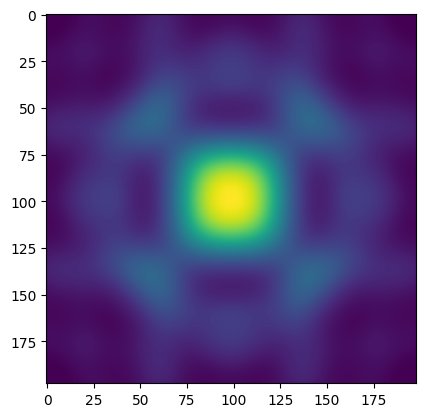

In [7]:
intensity = torch.abs(focal_plane[0, :, :]) ** 2
intensity = intensity.detach().cpu().numpy()
plt.imshow(intensity)

### Learning Curve

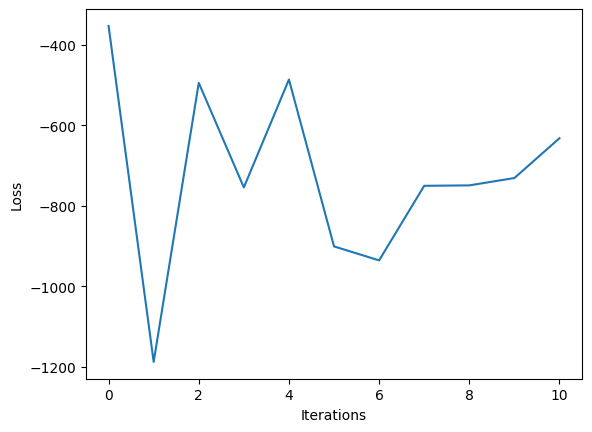

In [8]:
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Device Shape

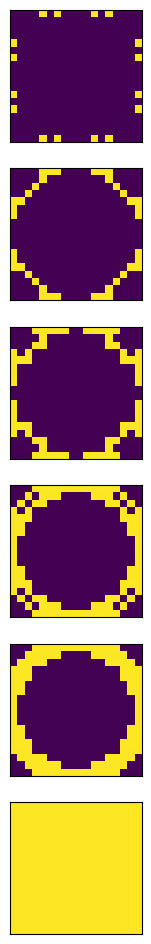

In [9]:
ER_t, UR_t = solver_metasurface_pt.generate_layered_metasurface(h, params)
solver_metasurface_pt.display_layered_metasurface(ER_t, params)